In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict


import tensorflow as tf
import os
import cv2
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Input
from tensorflow.keras import utils
from tensorflow.keras import datasets
from tensorflow.keras import preprocessing
from tensorflow.keras import metrics
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from pylab import rcParams
from tensorflow.keras import backend

In [7]:
train_path = '/mnt/hdd_data/bbayraktar/plant-pathology-2021-fgvc8/train_images_resized'
test_path = '/mnt/hdd_data/bbayraktar/plant-pathology-2021-fgvc8/test_images_resized'
df = pd.read_csv('/mnt/hdd_data/bbayraktar/plant-pathology-2021-fgvc8/train.csv')
df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [8]:
dct = defaultdict(list)

for i, label in enumerate(df.labels):
    for category in label.split():
        dct[category].append(i)

dct = {key: np.array(val) for key, val in dct.items()}
dct

{'healthy': array([    0,     5,     7, ..., 18626, 18627, 18631]),
 'scab': array([    1,     2,     3, ..., 18625, 18628, 18630]),
 'frog_eye_leaf_spot': array([    1,    14,    31, ..., 18612, 18619, 18630]),
 'complex': array([    1,     4,     8, ..., 18597, 18604, 18617]),
 'rust': array([    6,    21,    26, ..., 18601, 18616, 18629]),
 'powdery_mildew': array([   20,    39,    44, ..., 18532, 18617, 18618])}

In [9]:
new_df = pd.DataFrame(np.zeros((df.shape[0], len(dct.keys())), dtype = np.int8), columns = dct.keys())

for key, val in dct.items():
    new_df.loc[val, key] = 1

new_df.head()

,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
0,1,0,0,0,0,0
1,0,1,1,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0


In [10]:
new_df.sum(axis = 0)

healthy               4624
scab                  5712
frog_eye_leaf_spot    4352
complex               2151
rust                  2077
powdery_mildew        1271
dtype: int64

In [11]:
cats_total = new_df.sum(axis = 1).values

np.sort(cats_total)


array([1, 1, 1, ..., 3, 3, 3])

In [12]:
from collections import Counter

Counter(df.labels)

Counter({'healthy': 4624,
         'scab frog_eye_leaf_spot complex': 200,
         'scab': 4826,
         'complex': 1602,
         'rust': 1860,
         'frog_eye_leaf_spot': 3181,
         'powdery_mildew': 1184,
         'scab frog_eye_leaf_spot': 686,
         'frog_eye_leaf_spot complex': 165,
         'rust frog_eye_leaf_spot': 120,
         'powdery_mildew complex': 87,
         'rust complex': 97})

In [13]:
ks = {k: i for i,k in enumerate(Counter(df.labels).keys())}
new_df['labs'] = np.array([ks[v] for v in df.labels])
new_df['labs']

0        0
1        1
2        2
3        2
4        3
        ..
18627    0
18628    2
18629    4
18630    7
18631    0
Name: labs, Length: 18632, dtype: int64

In [14]:
new_df = pd.concat([df, new_df], axis = 1)

new_df.head()

,image,labels,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew,labs
0,800113bb65efe69e.jpg,healthy,1,0,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,0,1,1,1,0,0,1
2,80070f7fb5e2ccaa.jpg,scab,0,1,0,0,0,0,2
3,80077517781fb94f.jpg,scab,0,1,0,0,0,0,2
4,800cbf0ff87721f8.jpg,complex,0,0,0,1,0,0,3


In [15]:
target_columns = list(new_df.columns[2:-1])

target_columns

['healthy', 'scab', 'frog_eye_leaf_spot', 'complex', 'rust', 'powdery_mildew']

In [17]:
network_size = (224,224)
number_of_classes = 6

In [71]:
batch_size = 128
image_generator = preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    
    rotation_range=30, 
    zoom_range=0.15,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15,
    horizontal_flip=True, 
    vertical_flip=False,
    fill_mode="reflect"#,
    #validation_split = 0.3
  )



new_df = new_df.iloc[np.random.choice(new_df.shape[0], new_df.shape[0], replace = False),:]

skf = StratifiedKFold(n_splits = 8, shuffle = True, random_state = 1488)

train_ind, test_ind = next(skf.split(new_df, new_df['labs']))

train_generator = image_generator.flow_from_dataframe(
    dataframe = new_df.iloc[train_ind,:],
    directory = train_path,
    x_col="image",
    y_col = target_columns,
    weight_col=None,
    target_size = network_size,
    color_mode="rgb",

    class_mode="raw",
    batch_size=batch_size,
    shuffle=False,
    seed=None,

    #subset='training',
    interpolation="box"
)

validation_generator = image_generator.flow_from_dataframe(
    dataframe = new_df.iloc[test_ind,:],
    directory = train_path,
    x_col="image",
    y_col = target_columns,
    weight_col=None,
    target_size = network_size,
    color_mode="rgb",

    class_mode="raw",
    batch_size=batch_size,
    shuffle=False,
    seed=None,

    #subset='validation',
    interpolation="box"
)

Found 16303 validated image filenames.
Found 2329 validated image filenames.


In [72]:
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    recall = true_positives / (possible_positives + backend.epsilon())
    f1_val = 2*(precision * recall)/(precision+recall+ backend.epsilon())
    return f1_val

In [29]:
loaded_model = models.load_model('model_best.h5', custom_objects={"f1": f1})

In [78]:
y_pred = loaded_model.predict_generator(generator = validation_generator)

In [79]:
y_pred = np.round(y_pred)
y_pred.shape

(2329, 6)

In [80]:
gt = []
counter = 0
for batch in validation_generator:
    print(counter)
    counter += 1
    if(counter == 20):
        break
    for i , j in enumerate(batch[1]):
        gt.append(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [81]:
gt = np.asarray(gt)
gt.shape

(2329, 6)

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       578
           1       0.95      0.63      0.76       713
           2       0.87      0.85      0.86       544
           3       0.77      0.56      0.65       269
           4       0.74      0.96      0.84       261
           5       0.94      0.83      0.88       158

   micro avg       0.86      0.80      0.83      2523
   macro avg       0.86      0.80      0.82      2523
weighted avg       0.87      0.80      0.82      2523
 samples avg       0.84      0.82      0.83      2523



/home/bbayraktar/anaconda3/envs/lazyprogrammer/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


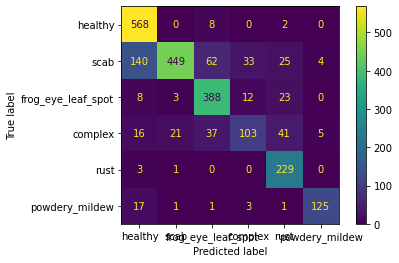

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
matrix = confusion_matrix(gt.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = ['healthy', 'scab', 'frog_eye_leaf_spot', 'complex', 'rust', 'powdery_mildew'])
disp.plot()

report = classification_report(gt, y_pred)
print(report)

In [84]:
from tensorflow import keras
test_df = pd.read_csv('/mnt/hdd_data/bbayraktar/plant-pathology-2021-fgvc8/sample_submission.csv')


test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255
)


test_generator = test_generator.flow_from_dataframe(
    dataframe= test_df,
    directory = test_path,
    x_col = "image",
    y_col = 'labels',
    target_size = network_size,
    color_mode="rgb",

    batch_size=1,
    shuffle=False,
    seed=None,

    subset=None,
    
    interpolation="box"
)

Found 3 validated image filenames belonging to 1 classes.


In [153]:
answer = loaded_model.predict(train_generator)



In [160]:
answer > 0.5
total_pred = []
for ans in answer:
    ans = ans > 0.5
    ids = np.where(ans)[0]
    pred_cls = []
    if ids.size == 0:
        pred_cls.append(target_columns[0])
    for id_ in ids:
        pred_cls.append(target_columns[id_])
    pred_cls = " ".join(pred_cls)
    total_pred.append(pred_cls)
    
train_df =  new_df.iloc[train_ind,:2]
train_df.to_csv('gt.csv', index = False)
train_df['labels'] = np.array(total_pred)
train_df.sort_index()
train_df.to_csv('pred.csv', index = False)
#new_df.iloc[train_ind,:]

In [56]:
test_df['labels'] = np.array(tot)

test_df

ValueError: Length of values (16303) does not match length of index (3)

In [ ]:
test_df.to_csv('submission_train.csv', index = False)